In [1]:
from apportionment import Apportionment
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.fft import fft, ifft
from scipy.signal import find_peaks
from scipy import signal

In [2]:
# Simulation parameters
voters = 1000000
num_seats = 150
nit = 100
group_size = 10000
link='NRSR2023_clean.csv'
file='test2811_11.csv'

ap = Apportionment(num_seats, voters, link=link) 
# -> TODO higher tresholds for coalitions
print("No of votes from source:", sum(ap.subject_votes.values()))
print("Considered votes:", ap.voters)
print("No. of seats:", num_seats)
weights = ap.subject_votes
# print(weights)

#apportionment test
result = ap.divide_seats("slovak")
if not (sum(result.values()) == 150): print(result.values()) 
else: print("seats ok")
if not (list(result.values()) == [32, 16, 11, 10, 42, 27, 12]): print(result.values()) 
else: print("apport ok")
print("Apportionment should work correctly.")

print("sum of probs:", sum(ap.probabilities.values()))
if not os.path.exists(file):
    ap.iterated_simulate('boxes', file, nit=nit, group_size=group_size)
else:
    print("Simulation did not happen, file already exists!")

link NRSR2023_clean.csv
No of votes from source: 4388872
Considered votes: 1000000
No. of seats: 150
seats ok
apport ok
Apportionment should work correctly.
sum of probs: 0.9999999999999998
Simulation did not happen, file already exists!


In [3]:
df = pd.read_csv('test2811_6.csv')
df['weight'] = df['party_number'].map(weights)

grouped_df = df.groupby('samples').mean().reset_index()
weighted_df = df.groupby('samples').apply(lambda x: np.average(x['diff'], weights=x['weight'])).reset_index(name='diff')


x_valuesg = grouped_df['samples']
y_valuesg = grouped_df['diff']


x_valuesw = weighted_df['samples']
y_valuesw = weighted_df['diff']


df = pd.read_csv('test2811_12.csv')
df['weight'] = df['party_number'].map(weights)

grouped_df = df.groupby('samples').mean().reset_index()
weighted_df = df.groupby('samples').apply(lambda x: np.average(x['diff'], weights=x['weight'])).reset_index(name='diff')

x_vals_gr = grouped_df['samples']
y_vals_gr = grouped_df['diff']

x_vals_we = weighted_df['samples']
y_vals_we = weighted_df['diff']

Seat change decreases (raw): 		 15 	  150
Seat change decreases (window=5): 	 0 	  16


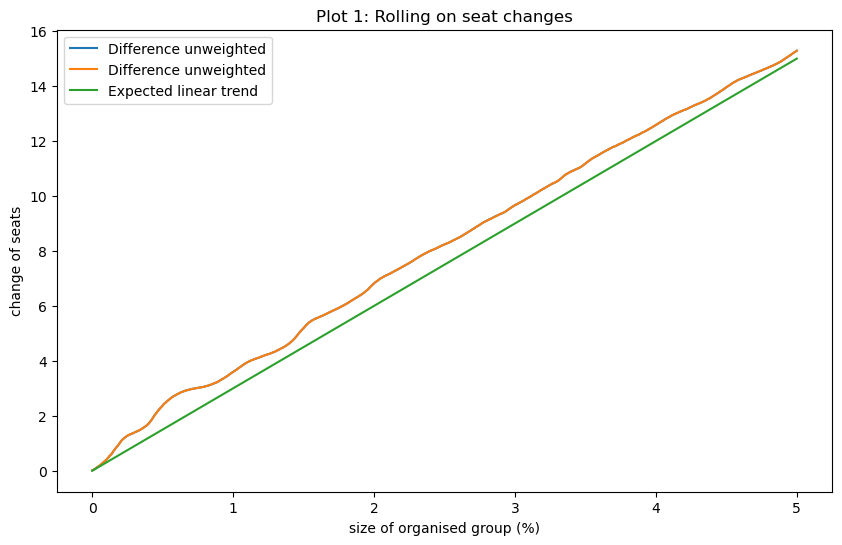

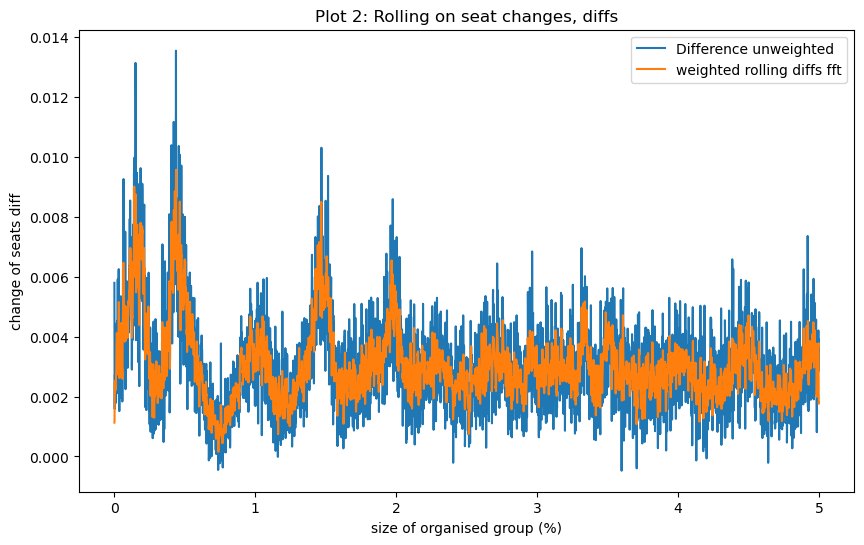

In [4]:
## rolling smoothing on pure result data comapred to smaller simulation

window = 5

# UNWEIGHTED

plt.figure(figsize=(10, 6))

y_roll_we = y_vals_we.rolling(window=window, center=True, min_periods=1).mean()
y_rollingw = y_valuesw.rolling(window=window, center=True, min_periods=1).mean()


plt.plot(x_vals_we / 1000, y_vals_we, '-', markersize=1, label='Difference unweighted')

plt.plot(x_vals_we / 1000, y_roll_we, '-', markersize=1, label='Difference unweighted')

x = np.arange(1, 5001)
y = (3/1000) * x

plt.plot(x / 1000, y, label='Expected linear trend')

plt.xlabel('size of organised group (%)')
plt.ylabel('change of seats')
plt.title('Plot 1: Rolling on seat changes')

plt.legend()


plt.figure(figsize=(10, 6))

y_diff_we = np.gradient(y_vals_we)
y_diff_roll_we = np.gradient(y_roll_we)

y_diffsw = np.gradient(y_valuesw)
y_diffs_rollingw = np.gradient(y_rollingw)

plt.plot(x_vals_gr / 1000, y_diff_we, '-', markersize=1, label='Difference unweighted')
plt.plot(x_vals_we / 1000, y_diff_roll_we, '-', markersize=1, label='weighted rolling diffs fft')


plt.xlabel('size of organised group (%)')
plt.ylabel('change of seats diff')
plt.title('Plot 2: Rolling on seat changes, diffs')

plt.legend()

print(f"Seat change decreases (raw): \t\t {sum(y_diff_we < 0)} \t  {sum(y_diffsw < 0)}")
print(f"Seat change decreases (window={window}): \t {sum(y_diff_roll_we < 0)} \t  {sum(y_diffs_rollingw < 0)}")

plt.show()




c:\Users\janko\anaconda3x\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


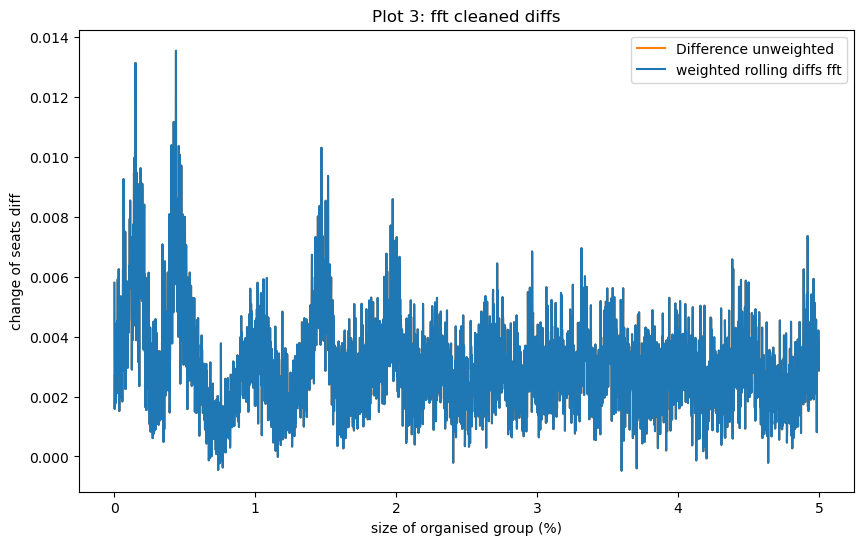

In [5]:
## FOURIER TRANSFORM NOICE CLEANING ONLY ON WEIGHTED

plt.figure(figsize=(10, 6))

y_diff_we = np.gradient(y_vals_we)

## FAST FOURIER TRANSFORM
y_transformed = fft(np.array(y_diff_we))

nyquist_freq = 0.5 * 5000  # Replace your_sampling_rate with the actual sampling rate

# Design a low-pass Butterworth filter
order = 14  # Adjust the filter order as needed
cutoff_frequency = 10  # Adjust the cutoff frequency as needed
b, a = signal.butter(14, .002, btype='low')

# Apply the filter to your data
filtered_data = signal.filtfilt(b, a, y_transformed)
# threshold = 1
# high_freq_components = np.where(np.abs(y_transformed) > threshold)
# y_transformed[high_freq_components] = 0
y_smoothed = ifft(y_transformed)

# plt.plot(x_vals_we / 1000, y_final_we, '-', markersize=1, label='weighted rolling diffs')
plt.plot(x_vals_gr / 1000, y_diff_we, '-', markersize=1, label='Difference unweighted', color='#ff7f0e')
plt.plot(x_vals_we / 1000, y_smoothed, '-', markersize=1, label='weighted rolling diffs fft')


plt.xlabel('size of organised group (%)')
plt.ylabel('change of seats diff')
plt.title('Plot 3: fft cleaned diffs')

plt.legend()
plt.show()


# -- fft with discrete values, not diffs

# plt.figure(figsize=(10, 6))

# ## FAST FOURIER TRANSFORM
# y_transformed = fft(np.array(y_vals_we))
# threshold = 1
# high_freq_components = np.where(np.abs(y_transformed) < threshold)
# y_transformed[high_freq_components] = 0
# y_smoothed = ifft(y_transformed)

# # plt.plot(x_vals_we / 1000, y_final_we, '-', markersize=1, label='weighted rolling diffs')
# plt.plot(x_vals_gr / 1000, np.gradient(y_vals_we), '-', markersize=1, label='Difference unweighted', color='#ff7f0e')
# plt.plot(x_vals_we / 1000, np.gradient(y_smoothed), '-', markersize=1, label='weighted rolling diffs fft')


# plt.xlabel('size of organised group (%)')
# plt.ylabel('change of seats')
# plt.title('Plot 3: Derivative weighted (100k, 5000)')

# plt.legend()
# plt.show()

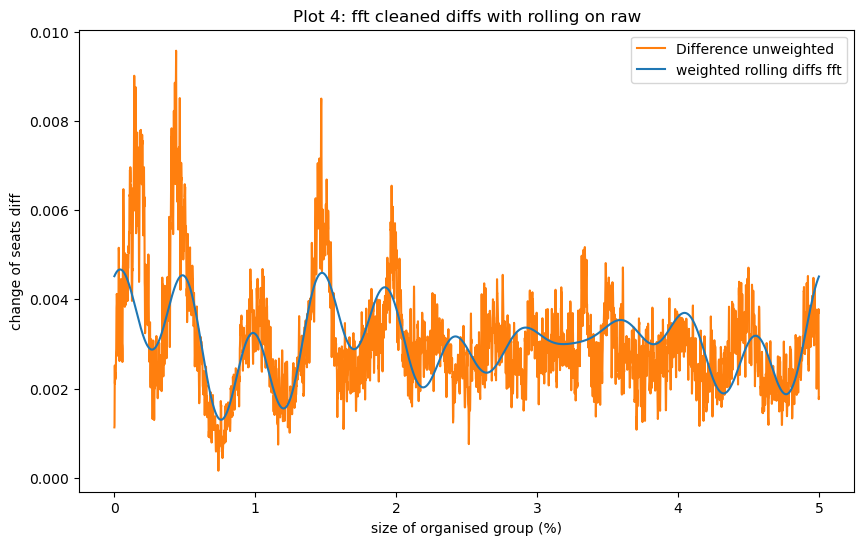

In [6]:
## FFT WITH ROLLING ON

plt.figure(figsize=(10, 6))

y_roll_diff_we = np.gradient(y_roll_we)

## FFT
y_transformed = fft(np.array(y_roll_diff_we))
threshold = 1
high_freq_components = np.where(np.abs(y_transformed) < threshold)
y_transformed[high_freq_components] = 0
y_roll_smoothed = ifft(y_transformed)

plt.plot(x_vals_gr / 1000, y_roll_diff_we, '-', markersize=1, label='Difference unweighted', color='#ff7f0e')
plt.plot(x_vals_we / 1000, y_roll_smoothed, '-', markersize=1, label='weighted rolling diffs fft')


plt.xlabel('size of organised group (%)')
plt.ylabel('change of seats diff')
plt.title('Plot 4: fft cleaned diffs with rolling on raw')

plt.legend()
plt.show()


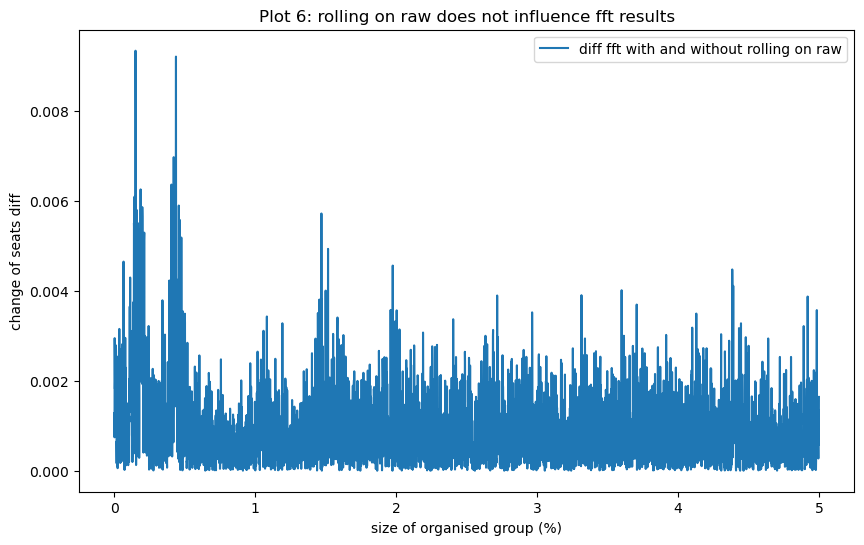

In [7]:
plt.figure(figsize=(10, 6))

plt.plot(x_vals_we / 1000, abs(y_smoothed - y_roll_smoothed), '-', markersize=1, label='diff fft with and without rolling on raw')

plt.xlabel('size of organised group (%)')
plt.ylabel('change of seats diff')
plt.title('Plot 6: rolling on raw does not influence fft results')

plt.legend()
plt.show()

c:\Users\janko\anaconda3x\Lib\site-packages\scipy\signal\_peak_finding.py:265: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


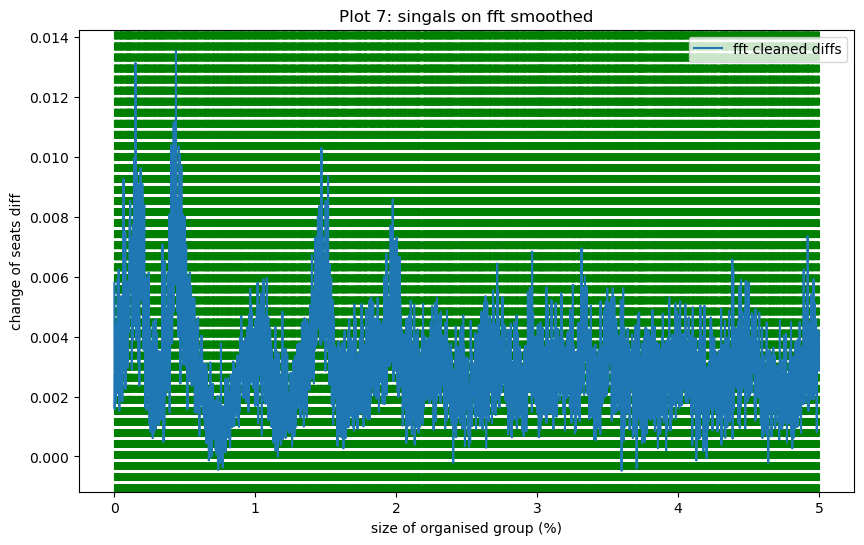

[3 3 3 ... 4 3 2]
Average peak distance: 4.102711585866886


In [8]:
## SIGNALS ON FFT DIFFS

plt.figure(figsize=(10, 6))

signal_data = y_smoothed

peaks, _ = find_peaks(signal_data, prominence=2e-4)

peak_distances = np.diff(peaks)

for x in peaks:
    plt.axvline(x=x/1000, color='g', linestyle='--')

plt.plot(x_vals_we / 1000, y_smoothed, '-', markersize=1, label='fft cleaned diffs')

plt.xlabel('size of organised group (%)')
plt.ylabel('change of seats diff')
plt.title('Plot 7: singals on fft smoothed')

plt.legend()
plt.show()

print(peak_distances)
print("Average peak distance:",peak_distances.mean())

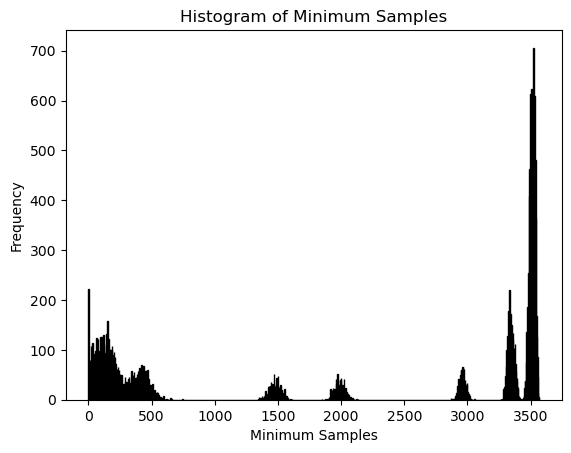

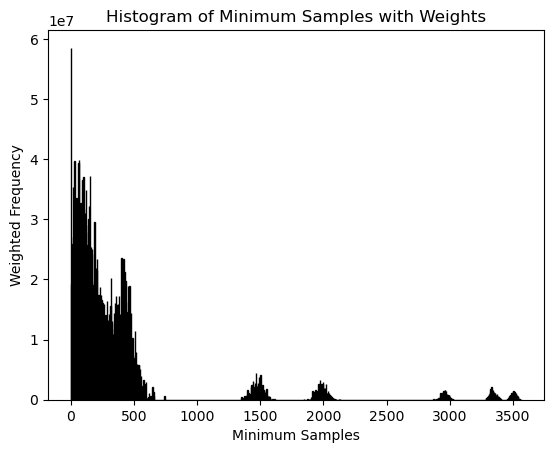

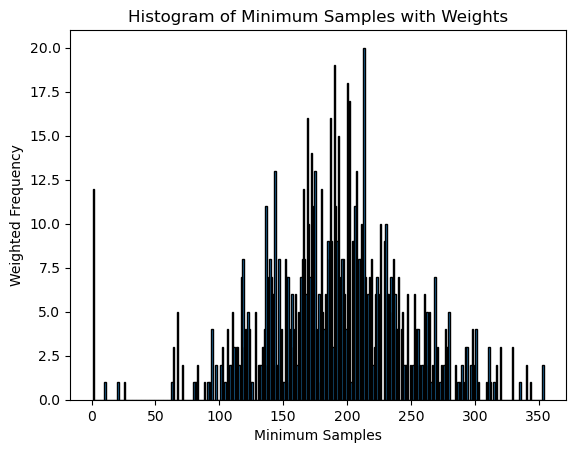

In [9]:
df = pd.read_csv('test2811_12.csv') 

filtered_df = df[df['diff'] != 0]

result_df = filtered_df.groupby(['interation_number', 'party_number'])['samples'].min().reset_index()

plt.hist(result_df['samples'], bins = 1000, edgecolor='black')
plt.xlabel('Minimum Samples')
plt.ylabel('Frequency')
plt.title('Histogram of Minimum Samples')
plt.show()

result_df = filtered_df.groupby(['interation_number', 'party_number'])['samples'].min().reset_index()

plt.hist(result_df['samples'], bins = 1000, edgecolor='black', weights=result_df['party_number'].map(weights))
plt.xlabel('Minimum Samples')
plt.ylabel('Weighted Frequency')
plt.title('Histogram of Minimum Samples with Weights')
plt.show()

df['weight'] = df['party_number'].map(weights)
average_df = df.groupby(['interation_number', 'samples']).apply(lambda x: np.average(x['diff'], weights=x['weight'])).reset_index(name='diff')
filtered_df = average_df[average_df['diff'] >= 1]


result_df = filtered_df.groupby(['interation_number'])['samples'].min().reset_index()

plt.hist(result_df['samples'], bins = 350, edgecolor='black')
plt.xlabel('Minimum Samples')
plt.ylabel('Weighted Frequency')
plt.title('Histogram of Minimum Samples with Weights')
plt.show()

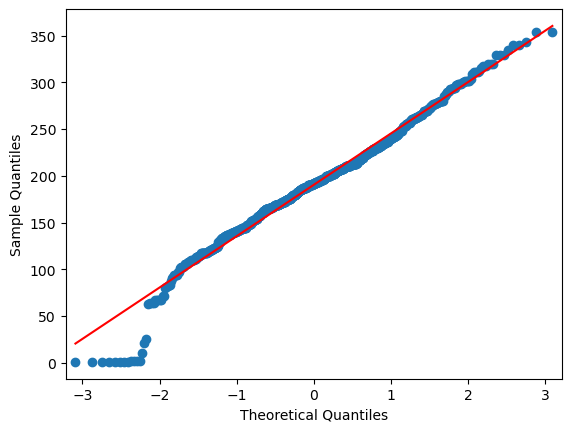

In [10]:
import statsmodels.api as sm
data = result_df['samples']

sm.qqplot(data, line='s')

plt.show()


In [11]:
from scipy.stats import shapiro, kstest


stat, p_value = shapiro(data)

# Print the test statistic and p-value
print(f"Test Statistic: {stat}, p-value: {p_value}")

stat, p_value = kstest(data, 'norm')

# Print the test statistic and p-value
print(f"Test Statistic: {stat}, p-value: {p_value}")

Test Statistic: 0.9808493852615356, p-value: 3.4202279897144194e-10
Test Statistic: 0.988, p-value: 0.0
